In [1]:
import numpy as np
import pandas as pd
import time
import sys
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#get data
in_file = '../../merge/reformatted_data_with_features.txt'
feature_type = 'TFBS'
metadata_columns = ['tumor_fraction','cancer_present','sample_type','Stage']

data = pd.read_csv(in_file, sep='\t')

data = data.set_index('sample')
data['status'] = data['cancer_present']

#get only the training samples used in delfi
training_samples = pd.read_csv("../../../../../metadata/cancer_detection/delfi_training_samples.txt", header=None)
data = data[data.index.isin(training_samples[0])].copy()

print(len(data))
print(data['sample_type'].value_counts())


423
Healthy              215
Breast_Cancer         54
Pancreatic_Cancer     34
Ovarian_Cancer        28
Gastric_cancer        27
Colorectal_Cancer     27
Bile_Duct_Cancer      25
Lung_Cancer           12
Duodenal_Cancer        1
Name: sample_type, dtype: int64


In [3]:
#view data
data.head()

,tumor_fraction,sample_type,cancer_present,Stage,central_cov_AHR.hg38,central_cov_AR.hg38,central_cov_ARID3A.hg38,central_cov_ARNT.hg38,central_cov_ARNTL.hg38,central_cov_ASCL1.hg38,...,mean_cov_ZNF554.hg38,mean_cov_ZNF574.hg38,mean_cov_ZNF580.hg38,mean_cov_ZNF652.hg38,mean_cov_ZNF770.hg38,mean_cov_ZNF792.hg38,mean_cov_ZSCAN16.hg38,mean_cov_ZSCAN22.hg38,mean_cov_ZSCAN9.hg38,status
sample,,,,,,,,,,,,,,,,,,,,,
Bile_Duct_Cancer_CGPLPA114,0.00000,Bile_Duct_Cancer,1,II,0.987258,1.069317,1.039260,0.964137,1.063988,1.005535,...,0.978447,0.909069,0.911800,0.965919,0.965969,0.918734,0.949356,0.912786,0.912877,1
Bile_Duct_Cancer_CGPLPA115,0.14790,Bile_Duct_Cancer,1,IV,0.977638,1.083322,1.047342,0.965163,1.068265,1.024070,...,0.981533,0.922064,0.926570,0.971589,0.960835,0.930276,0.952652,0.921692,0.928423,1
Bile_Duct_Cancer_CGPLPA117,0.00000,Bile_Duct_Cancer,1,II,0.966465,1.037142,0.999035,0.948562,1.036125,1.014597,...,0.981376,0.913154,0.917178,0.967296,0.968776,0.926727,0.944984,0.914875,0.921302,1
Bile_Duct_Cancer_CGPLPA118,0.03099,Bile_Duct_Cancer,1,I,0.969590,1.060113,1.002355,0.955208,1.060563,1.022950,...,0.977465,0.899795,0.903280,0.961533,0.964977,0.909292,0.942476,0.908216,0.906387,1
Bile_Duct_Cancer_CGPLPA122,0.04570,Bile_Duct_Cancer,1,II,0.971078,1.056560,0.968468,0.964135,1.084615,1.042645,...,0.976797,0.897642,0.892573,0.946538,0.960682,0.889728,0.951610,0.903162,0.887241,1


In [4]:
#get a list of all possible features
features = data.columns.drop(['status']+metadata_columns)

#these two should be the seame
print(len(features))
print(len(features[features.str.contains('fft_10_magnitude')])*3)

1014
1014


In [5]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

central_cov_AHR.hg38       1.263502e-15
central_cov_AR.hg38       -7.645578e-16
central_cov_ARID3A.hg38    9.642930e-16
central_cov_ARNT.hg38      2.637764e-15
central_cov_ARNTL.hg38    -6.335883e-16
                               ...     
mean_cov_ZNF770.hg38       2.692251e-14
mean_cov_ZNF792.hg38      -1.507384e-14
mean_cov_ZSCAN16.hg38     -3.034085e-16
mean_cov_ZSCAN22.hg38     -1.457201e-15
mean_cov_ZSCAN9.hg38       6.852937e-16
Length: 1014, dtype: float64

In [6]:
#Leave one out nested cross validation
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()
n_iter = 1000

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

# Loop for each iteration
for i in range(n_iter):
    if i%50==0:
        print(i, time.time()-start_time)
        sys.stdout.flush()
    
    #bootstrap a training set with replacement
    training = data.sample(len(data), replace = True, random_state = i+100)
    
    #the test set is all samples that aren't seen in the training data
    test = data[~(data.index.isin(training.index))]
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = i+100) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 1)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)

probabilities = probabilities.merge(data[metadata_columns+['status']], left_index=True, right_index=True)

0 0.0014922618865966797
50 85.7843849658966
100 168.3371171951294
150 237.7660689353943
200 310.198557138443
250 384.6341760158539
300 458.14169788360596
350 525.5666971206665
400 598.0630388259888
450 669.6909520626068
500 741.9463458061218
550 813.4045238494873
600 887.6334900856018
650 960.2083220481873
700 1029.8789229393005
750 1099.6837220191956
800 1168.781841993332
850 1237.9902381896973
900 1307.510048866272
950 1380.0593461990356


In [7]:
probabilities.to_csv(feature_type+'_results/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(feature_type+'_results/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(feature_type+'_results/coefs.txt', sep='\t')

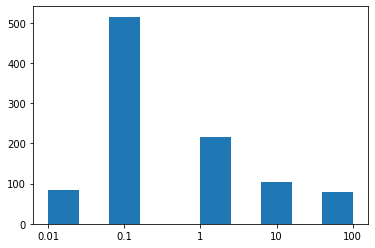

In [8]:
plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(feature_type+'_results/cvals.pdf')